In [1]:
!nvidia-smi

Wed Dec  3 20:32:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off |   00000000:B2:00.0 Off |                  N/A |
| 22%   24C    P8             19W /  250W |       1MiB /  11264MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
def print_gpu_memory():
    import torch
    if not torch.cuda.is_available():
        print("CUDA not available")
        return
    
    total = torch.cuda.get_device_properties(0).total_memory / 1e9
    allocated = torch.cuda.memory_allocated(0) / 1e9
    reserved = torch.cuda.memory_reserved(0) / 1e9
    free = total - allocated
    
    print(f"GPU Memory Summary:")
    print(f"  Total:     {total:.2f} GB")
    print(f"  Allocated: {allocated:.2f} GB")
    print(f"  Reserved:  {reserved:.2f} GB")
    print(f"  Free:      {free:.2f} GB")
    
print_gpu_memory()

GPU Memory Summary:
  Total:     11.35 GB
  Allocated: 0.00 GB
  Reserved:  0.00 GB
  Free:      11.35 GB


In [3]:
import os
# NOTE!
# this is for a multi-gpu setup. we basically set which GPU is visible for the program.
# if you only have one GPU (most likely the case ;) ), make sure this is set to "0"!
# or remove this line completely!
# otherwise you may accidentally make your GPU "invisible" to the program!
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
import os
os.chdir("/home/exgr5/LGM/Assignments")
print(os.getcwd())

/home/exgr5/LGM/Assignments


# Pytorch GAN

In [5]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn

from lgm.common import count_parameters, plot_learning_curves, EMA, sum_except
from lgm.data import get_datasets_and_loaders, Normalize
from lgm.gan import GANTrainer, GAN, Discriminator, Generator, SDLayer
from lgm.layers import hidden_linear, CNNBody, Reshape, ConvBlockPrenorm

torch.set_float32_matmul_precision('high')
torch.backends.cudnn.benchmark = True

/home/exgr5/LGM/lib/python3.12/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


In [6]:
torch.cuda.empty_cache()


## Data

We make one change to the data processing: We scale the images to [-1, 1] instead of [0, 1]. This is said to improve performance for GANs. To be honest, I think with modern architectures including normalization layers etc, this makes little difference. But we can try it anyway. :) 

The `Normalize` transform generally takes a mean and standard deviation and first subtracts the mean, then divides by the standard deviation. In this case, taking images in [0, 1] and subtracting 0.5 gives a scaling in [-0.5, 0.5], then dividing by 0.5 gets it to [-1, 1]. We could also compute the actual mean and standard deviation of the data and use that for normalization. This would make our data have mean 0 and standard deviation 1. Note that the functionality for this is already in the repository, and we will employ this for some other models later.

In any case, since most plotting functions expect images to be in the range [0, 1], wherever we plot stuff, we pass a `descale` function that reverses the transformation back into the [0, 1] range.
We also have to be mindful that our generator now has to produce values in the [-1, 1] range!
Finally, note that none of this is really specific to GANs; we could rescale our data for any generative model, and it may have a positive effect in some cases.

Shape/dtype of batch X [N, C, H, W]: torch.Size([256, 1, 32, 32]), torch.float32
Shape/dtype of batch y: torch.Size([256]), torch.int64


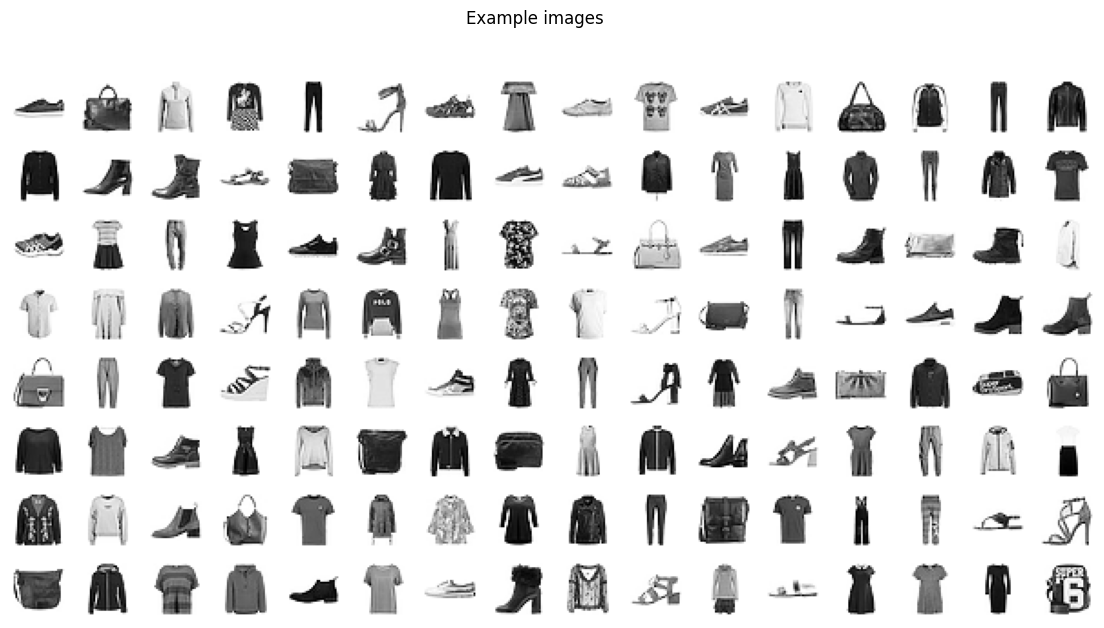

In [7]:
data = "fashion"
batch_size = 256

def descale_data(imgs):
    return 0.5 * (imgs + 1)

train_data, test_data, train_dataloader, test_dataloader = get_datasets_and_loaders(data, batch_size, num_workers=16,
                                                                                    additional_transforms=[Normalize(0.5, 0.5)],
                                                                                    plot_descale=descale_data)

## Model

We largely use the same architecture "recipe" as for VAEs. This is interesting, as we can see the differences between models with _the same neural network architecture_, but trained in different frameworks. In particular, GAN outputs are generally much sharper than VAEs. But this shows that this is _not_ a limitation of the networks we use -- rather it is the VAE framework itself that results in blurry outputs!

Because of the similarity, we are already supplying much of the code to get a functioning architecture.
Refer back to previous models to get ideas for how to fill in the remaining details.
**You are of course free to change anything you want!**

Do note the `Tanh` activation in the final generator layer. This makes sure the outputs are in the range [-1, 1]. Another important point is the use of `GroupNorm` instead of batch normalization in the discriminator. If you are interested in why that is, we wrote [an article about this on our blog](https://ovgu-ailab.github.io/blog/methods/2022/07/07/batchnorm-gans.html) a while ago. :)

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def create_gan_model(train_dataloader, batch_size):
    level_filters = [128, 64]  
    level_strides = [1, 2]  
    blocks_per_level = [2, 2]  
    kernel_size = 3
    activation = nn.Mish
    n_levels = len(level_filters)

    disc_global_pool = True  # whether the final convolutional feature maps are pooled before flattening to a vector
    gen_unflatten = True  # whether the generator noise is created as a vector (True), or directly in image shape (False)
    # e.g. as vector it would sth like shape (128,).
    # in "image shape" it would be sth like (128, 4, 4) so 4x4 pixels.

    input_shape = next(iter(train_dataloader))[0].shape[1:]
    input_pixels = input_shape[1]
    final_pixels = input_pixels // (2**(n_levels-1))

    input_channels = input_shape[0]
    final_filters = level_filters[-1] 

    # recipe for a fairly standard residual block + squeeze-and-excite (use_se)
    block_fn = ConvBlockPrenorm
    block_kwargs = {
        "n_layers": 2,
        "activation": activation,
        "kernel_size": kernel_size,
        "use_se": True,
        "se_reduction_factor": 8,
        "se_bias": 1.,
        "use_residual": True,
        "bottleneck_factor": 1
    }

    # NOTE that we supply nn.GroupNorm for the normalization, replacing the BatchNorm default!
    # passing -8 to norm_groups will be interpreted as creating groups of 8 filters (instead of 8 groups total).
    disc_initial = nn.Conv2d(input_channels, level_filters[0], kernel_size, padding="same")
    disc_body = CNNBody(blocks_per_level,
        level_filters,
        level_strides,
        input_channels=level_filters[0],
        direction="down",
        block_fn=block_fn,
        return_all=True,
        norm=nn.GroupNorm,
        norm_groups=-8,
        **block_kwargs
    )
    disc_head = nn.Sequential()
    if disc_global_pool:
        disc_head.append(nn.AdaptiveAvgPool2d(1))
    disc_head.append(nn.Flatten())
    disc_head.append(nn.LazyLinear(1))

    discriminator = Discriminator(disc_initial, disc_body, disc_head)

    # in case of gen_unflatten: The total dimensionality of the noise
    # in case of gen_unflatten is False: The number of *channels* in the noise "image"
    noise_dim = 128

    if gen_unflatten:
        noise_shape = (noise_dim,)
    else:
        noise_shape = (noise_dim, final_pixels, final_pixels)

    # you can experiment with other random functions! anything goes! no backpropagation needed!
    def noise_fn(batch_size):
        return torch.randn(batch_size, *noise_shape)

    generator = Generator(noise_fn)
    if gen_unflatten:
        generator.append(nn.Linear(noise_dim, final_pixels * final_pixels * final_filters))
        generator.append(Reshape((-1, final_filters, final_pixels, final_pixels)))
    else:
        generator.append(nn.Conv2d(noise_dim, final_filters, 1))
    # for the generator, batchnorm is OK
    generator.append(
        CNNBody(
            blocks_per_level,
            list(reversed(level_filters)),
            list(reversed(level_strides)),
            input_channels=final_filters,
            direction="up",
            block_fn=block_fn,
            **block_kwargs
        )
    )
    generator.append(nn.Conv2d(level_filters[0], input_channels, 1))
    generator.append(nn.Tanh())

    # we have to run the model once to initialize the lazy layers
    discriminator = discriminator.to(device)
    generator = generator.to(device)
    with torch.no_grad():
        d_test_output = discriminator(next(iter(train_dataloader))[0].to(device))
        g_test_output = generator.generate(batch_size)

    print("\n")
    print("discrminator test output shape")
    print(d_test_output[0].shape)
    print("generator test output shape")
    print(g_test_output.shape)
    if g_test_output.shape[1] != input_channels:
        print("WARNING! Expected {} output channels but got {}".format(input_channels, g_test_output.shape[1]))
    if g_test_output.shape[2] != input_pixels:
        print("WARNING! Expected {} output pixels but got {}".format(input_pixels, g_test_output.shape[2]))

    model = GAN(generator, discriminator)
    return model


In [9]:
model = create_gan_model(train_dataloader,batch_size)



discrminator test output shape
torch.Size([256, 1])
generator test output shape
torch.Size([256, 1, 32, 32])


In [10]:
num_params = count_parameters(model.discriminator)
print(f"Discriminator with {num_params:,} trainable parameters")

num_params = count_parameters(model.generator)
print(f"Generator with {num_params:,} trainable parameters")

Discriminator with 796,209 trainable parameters
Generator with 2,797,873 trainable parameters


## Training

On the surface, training looks much the same as for VAEs. Note: GAN training takes a bit longer, since we have to run two models. Start early!

In [11]:
n_epochs = 150

optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.1, amsgrad=False)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

trainer = GANTrainer(model=model,
                     loss_fn=nn.BCEWithLogitsLoss(),
                     optimizer=optimizer, scheduler=scheduler,
                     training_loader=train_dataloader, validation_loader=test_dataloader,
                     n_epochs=n_epochs, device=device, plot_every_n_epochs=10, verbose=True,
                     plot_descale=descale_data)

In [12]:
print_gpu_memory()

GPU Memory Summary:
  Total:     11.35 GB
  Allocated: 0.02 GB
  Reserved:  0.50 GB
  Free:      11.32 GB


In [ ]:
metrics = trainer.train_model()

We can plot the losses here for completion, but honestly they are usually not very relevant for GANs...

In [14]:
trainer.evaluate()

(tensor(0.4323, device='cuda:0'),
 defaultdict(float,
             {'discriminator_loss': tensor(0.4323, device='cuda:0'),
              'generator_loss': tensor(1.5021, device='cuda:0')}))

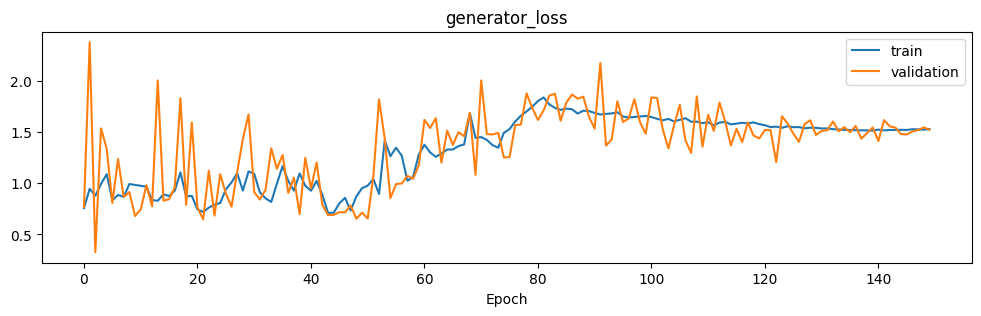

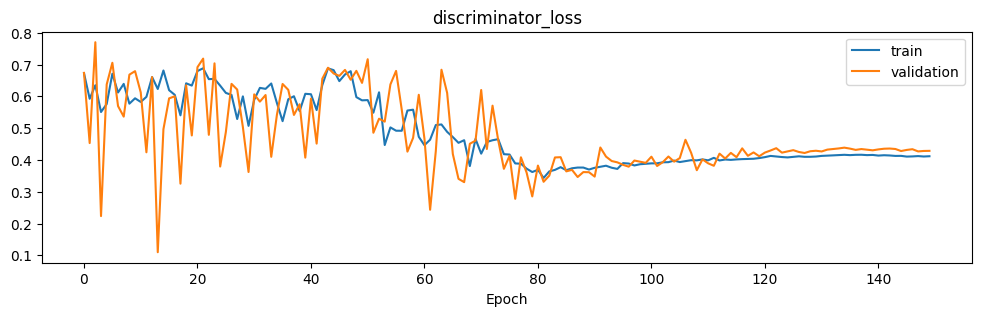

In [15]:
# note: with feature matching, use ["generator_loss_classification", "feature_matching_loss", "discriminator_loss"]
plot_learning_curves(metrics, ["generator_loss", "discriminator_loss"])

Generating images is as easy with a GAN as with a VAE. Here we take extra care to revert the re-scaling of the data, so the images are back in the range [0, 1].

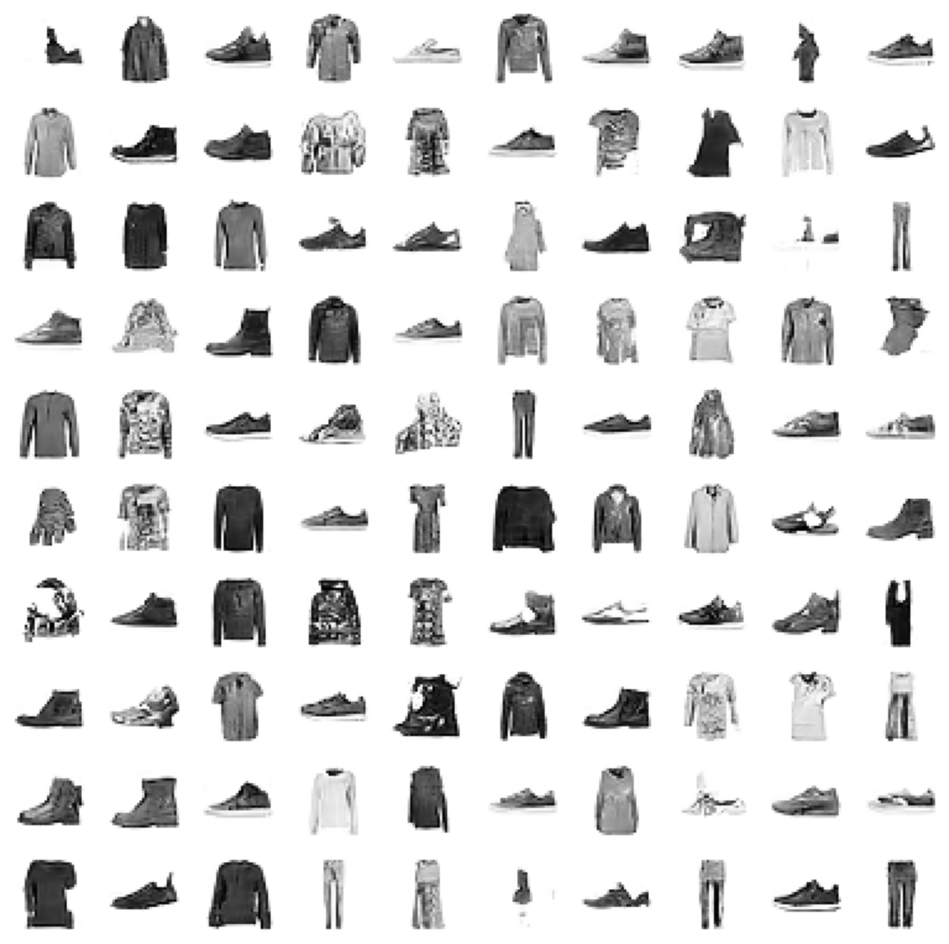

In [39]:
def generate_images(grid_size=(10, 10), figsize=(12, 12),generator = None):   
    with torch.no_grad():
        generated = descale_data(generator.generate(np.prod(grid_size)))
        generated = generated.cpu().numpy().transpose(0, 2, 3, 1)
        
    plt.figure(figsize=figsize)
    for ind, img in enumerate(generated):
        plt.subplot(*grid_size, ind + 1)
        plt.imshow(img, cmap="Greys", vmin=0, vmax=1)
        plt.axis("off")
    plt.show()

generate_images(generator = model.generator)

## Bag of Tricks

Here are some sketches for adding the improvements outlined in the assignment text.

### Optimizer improvements
You can reduce the learning rate by passing, for example, `lr=0.0002` (or some other number) to the optimizer.
You can also reduce the momentum by passing the `betas` argument, e.g. `betas=(0.5, 0.999)` would reduce momentum (`beta_1`) to 0.5 instead of the default 0.9.

In [ ]:
n_epochs = 150
model_optimizer_imp = create_gan_model(train_dataloader, batch_size)

optimizer = torch.optim.AdamW(model_optimizer_imp.parameters(),lr = 0.0002, betas = (0.5,0.99) , weight_decay=0.1, amsgrad=False)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

trainer_optimizer_imp = GANTrainer(model=model_optimizer_imp,
                     loss_fn=nn.BCEWithLogitsLoss(),
                     optimizer=optimizer, scheduler=scheduler,
                     training_loader=train_dataloader, validation_loader=test_dataloader,
                     n_epochs=n_epochs, device=device, plot_every_n_epochs=10, verbose=True,
                     plot_descale=descale_data)


metrics_optimizer_imp = trainer_optimizer_imp.train_model()
generate_images(generator = model_optimizer_imp.generator)

### LSGAN
Replace the `loss_fn` of the trainer with `nn.MSELoss()`

In [ ]:
n_epochs = 150
model_loss_mse = create_gan_model(train_dataloader, batch_size)

optimizer = torch.optim.AdamW(model_loss_mse.parameters(), weight_decay=0.1, amsgrad=False)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

trainer_loss_mse = GANTrainer(model=model_loss_mse,
                     loss_fn=nn.MSELoss(),
                     optimizer=optimizer, scheduler=scheduler,
                     training_loader=train_dataloader, validation_loader=test_dataloader,
                     n_epochs=n_epochs, device=device, plot_every_n_epochs=10, verbose=True,
                     plot_descale=descale_data)


metrics_loss_mse = trainer_loss_mse.train_model()
generate_images(generator = model_loss_mse.generator)


### Noise scale
Same here. Pass a small amount of noise (relative to the data scale) to the parameter `noise_scale`, e.g. `1/255` corresponds to a standard deviation of "one brightness value" given that images are originally integer values between 0 and 255. But when rescaling data to [-1, 1], you could double it to `1/127.5`.

In [ ]:
n_epochs = 150
model_noise = create_gan_model(train_dataloader, batch_size)
noise_scale = 1/127.5
optimizer = torch.optim.AdamW(model_noise.parameters(), weight_decay=0.1, amsgrad=False)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

trainer_noise = GANTrainer(model=model_noise,
                     loss_fn=nn.BCEWithLogitsLoss(),
                     optimizer=optimizer, scheduler=scheduler,
                     training_loader=train_dataloader, validation_loader=test_dataloader,
                     n_epochs=n_epochs, device=device, plot_every_n_epochs=10, verbose=True,
                     plot_descale=descale_data, noise_scale = noise_scale)


metrics_noise = trainer_noise.train_model()
generate_images(generator = model_noise.generator)

### Feature matching
Finish the implementation in `lgm.gan` and then pass `feature_matching=True` to the trainer object!

In [ ]:
n_epochs = 150
model_feature_matching = create_gan_model(train_dataloader, batch_size)

optimizer = torch.optim.AdamW(model_feature_matching.parameters(), weight_decay=0.1, amsgrad=False)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

trainer_feature_matching = GANTrainer(model=model_feature_matching,
                     loss_fn=nn.MSELoss(),
                     optimizer=optimizer, scheduler=scheduler,
                     training_loader=train_dataloader, validation_loader=test_dataloader,
                     n_epochs=n_epochs, device=device, plot_every_n_epochs=10, verbose=True,
                     plot_descale=descale_data, feature_matching = 'sum')




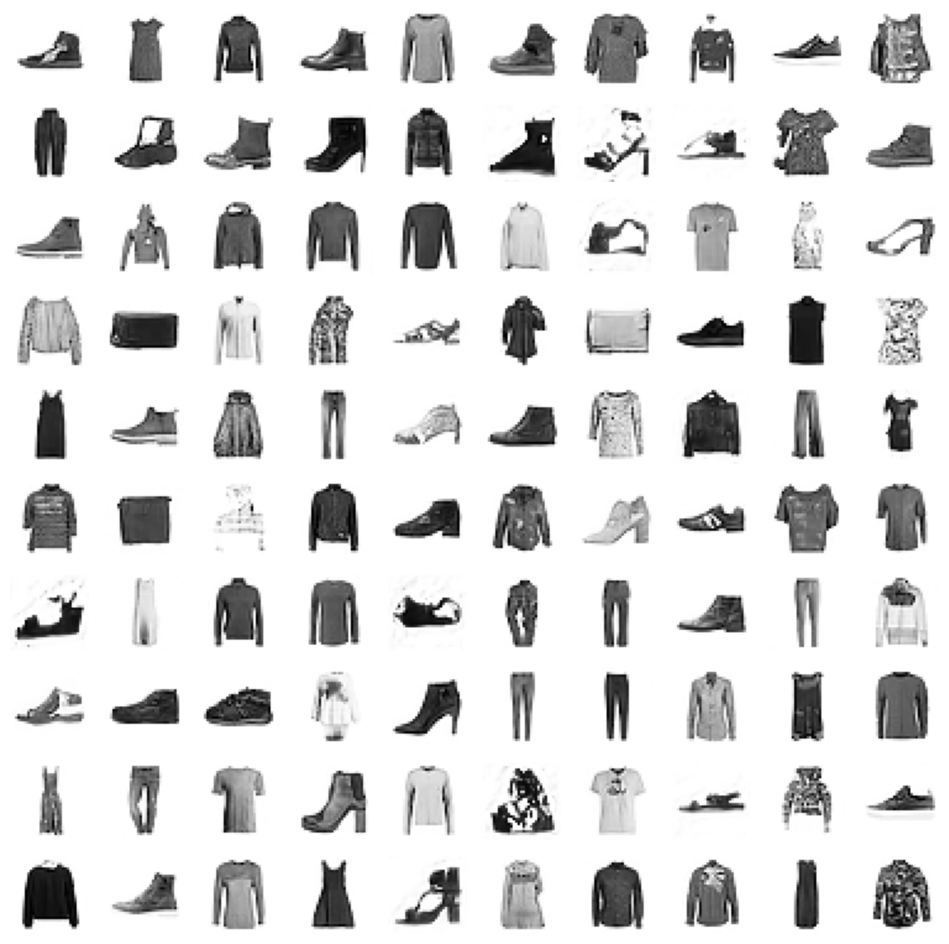

In [40]:
generate_images(generator = model_feature_matching.generator)

### Observations
1. GANs (Default beta and lr) and GANs (beta=(0.5,0.99), lr=0.0002) generated images that look similar to each other.
2. GAN with MSE (LGAN) and GAN with Feature Matching generated images from different classes, and very few images appeared similar to one another.

GANs (Default beta and lr)


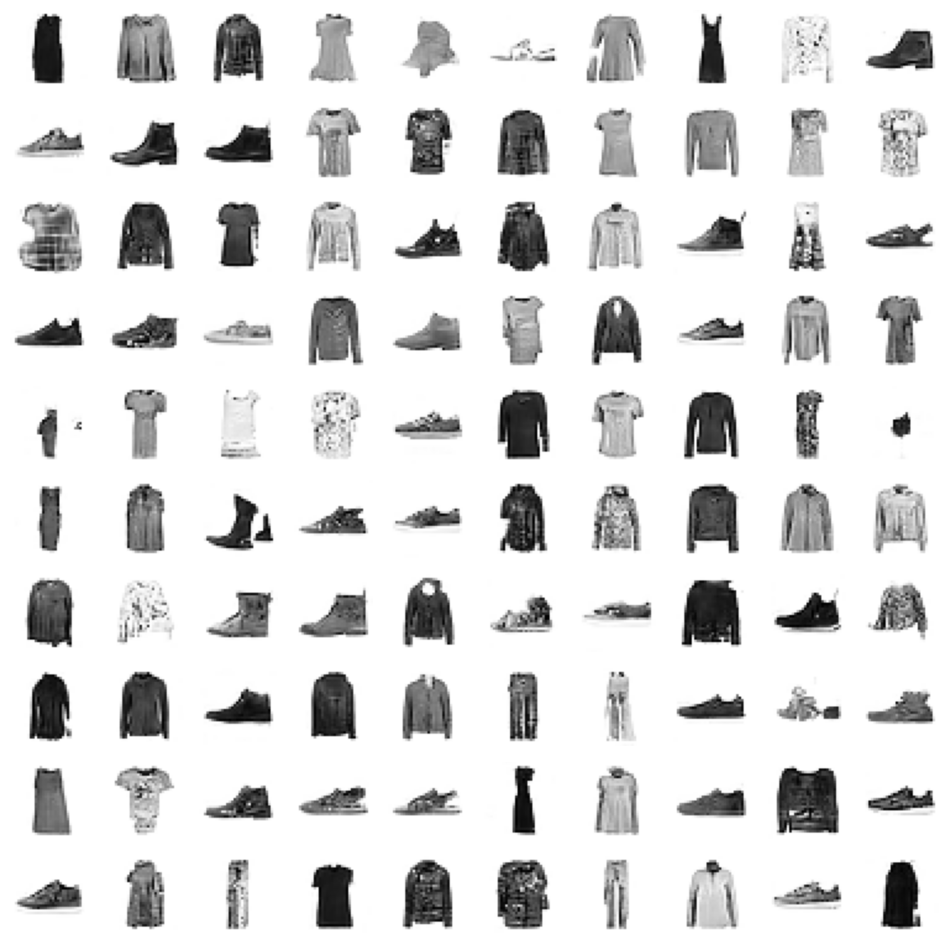

GANs (beta=(0.5,0.99), lr=0.0002)


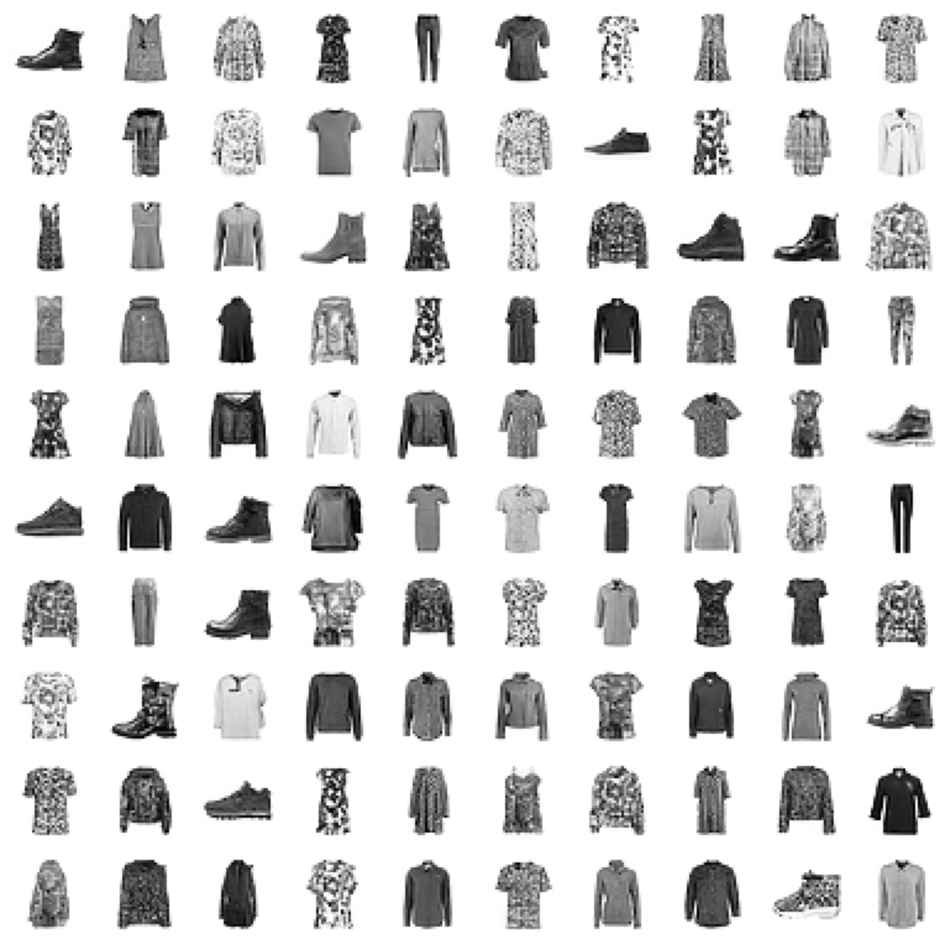

GAN with MSE (LGAN)


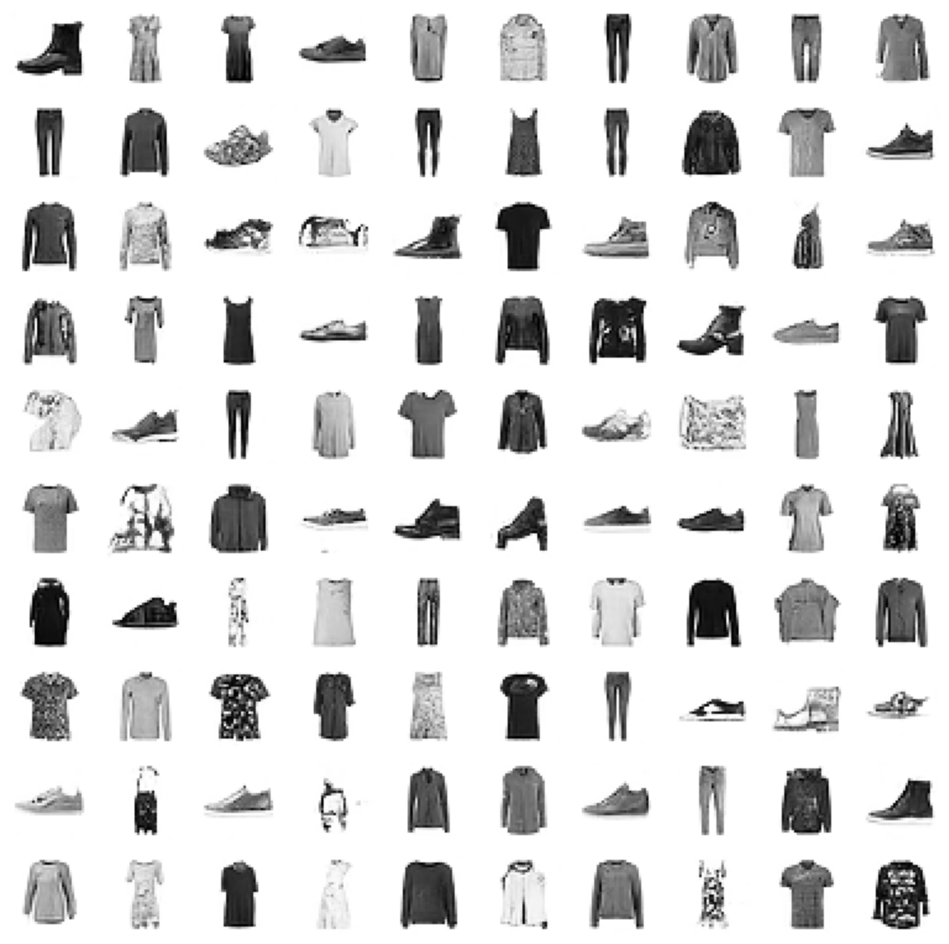

GAN with Feature Matching


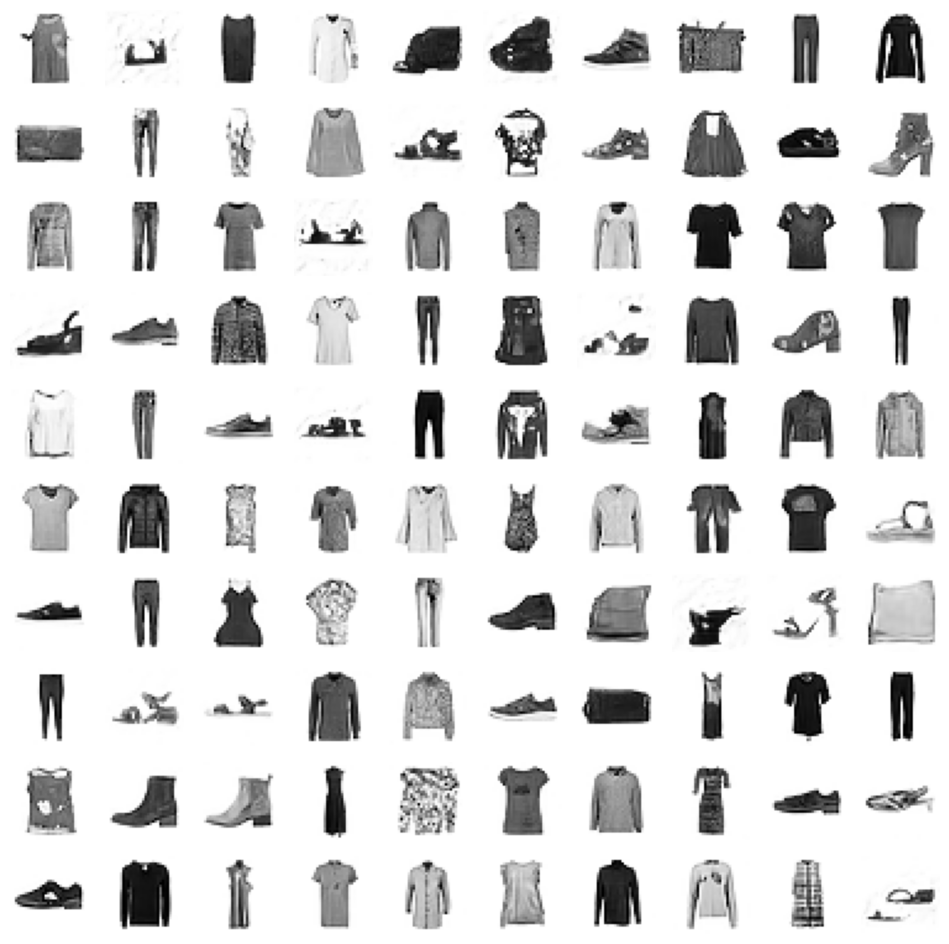

In [42]:
generators = [
    (model.generator, "GANs (Default beta and lr)"),
    (model_optimizer_imp.generator, "GANs (beta=(0.5,0.99), lr=0.0002)"),
    (model_loss_mse.generator, "GAN with MSE (LGAN)"),
    (model_feature_matching.generator, "GAN with Feature Matching")
]


for gen, title in generators:
    print(title)
    generate_images_grid(gen, grid_size=(10, 10), figsize=(12, 12))


## Bonus: GAN Inference Through Optimization

Doctors told this man that GANs couldn't do inference. He didn't believe them. This is him, 1000 optimization steps later:

...Anyway, what we are doing here is:
- Start with randomly initialized noise.
- Send the noise through the GAN to get an image output.
- Compare this to the desired image we want to "encode" via some difference function.
- Backpropagate into the noise and adapt it such that the output will be closer to the desired target.
- Repeat the three steps above until convergence.

Thus, we can do "inference" by finding a noise vector that closely correspond to a desired target image.
However, there is no guarantee that the GAN can really match the target (but then again, neither do VAE reconstructions match the inputs).

There is also no guarantee that the optimized noise vector will correspond to the prior we used to train the model.
That is why we add a regularizer that encourages the vector to have a norm similar to what would be expected of Standard Normal samples ($\sqrt{d}$ where $d$ is the dimensionality of the noise space).

NOTE this entire thing will change if you change the `noise_fn` above! Then this regularizer will no longer be valid.

In [ ]:
target_images = next(iter(test_dataloader))[0].to(device)

In [ ]:
n_steps = 5000
optimized_noise = noise_fn(target_images.shape[0]).to(device)
optimized_noise.requires_grad = True
noise_optimizer = torch.optim.Adam([optimized_noise], lr=1.)
noise_schedule = torch.optim.lr_scheduler.CosineAnnealingLR(noise_optimizer, n_steps)

reg_factor = 0.1

for step in range(n_steps + 1):
    outputs = model.generator(optimized_noise)
    diff = (outputs - target_images).abs().mean(dim=(1,2,3)).sum()

    ideal_norm = torch.sqrt(torch.tensor(np.prod(noise_shape)))
    actual_norms = torch.sqrt(sum_except(optimized_noise**2))
    diff = diff + reg_factor * ((ideal_norm - actual_norms)**2).mean()

    diff.backward(inputs=[optimized_noise])
    noise_optimizer.step()
    noise_optimizer.zero_grad()
    noise_schedule.step()

    if not step % (n_steps // 10):
        plt.figure(figsize=(8,8))
        for ind, img in enumerate(descale_data(outputs).detach().cpu().numpy()[:32]):
            target_here = descale_data(target_images[ind]).cpu().numpy()
            combined = np.concatenate((img, target_here), axis=2)
            plt.subplot(8, 4, ind + 1)
            plt.imshow(combined.transpose(1,2,0), cmap="Greys", vmin=0, vmax=1)
            plt.axis("off")
        plt.suptitle(f"After Step {step + 1}")
        plt.show()

Here we can compare the optimized noise norms to random noise norms.

In [ ]:
random_noise = noise_fn(batch_size)
random_norms = torch.sqrt(sum_except(random_noise**2))
plt.hist(random_norms, bins=20)
plt.show()

optimized_norms = torch.sqrt(sum_except(optimized_noise**2)).detach().cpu()
plt.hist(optimized_norms, bins=20)
plt.show()